In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces

 99% 436M/441M [00:17<00:00, 23.3MB/s]
100% 441M/441M [00:17<00:00, 26.5MB/s]


In [ ]:
!unzip anime-faces.zip

In [ ]:
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import cv2 
from glob import glob

import tensorflow as tf 
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose,Input,Flatten,Dense,Dropout,Reshape,Activation
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.optimizers import Adam

In [ ]:
list_data= os.listdir("data")
print(len(list_data))

21552


In [ ]:
#dataset pipeline 
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize_with_crop_or_pad(img, 64, 64)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [ ]:
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


In [ ]:
# discriminator
def discriminator():
  input_layer = Input(shape=(64,64,3))
  x= Conv2D(64,kernel_size=5,padding="same",kernel_initializer=w_init,strides=2)(input_layer) #block-1
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.3)(x)

  x= Conv2D(128,kernel_size=5,padding="same",kernel_initializer=w_init,strides=2)(x) #block-2
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.3)(x)

  x= Conv2D(256,kernel_size=5,padding="same",kernel_initializer=w_init,strides=2)(x) #block-3
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.3)(x)

  x= Conv2D(512,kernel_size=5,padding="same",kernel_initializer=w_init,strides=2)(x) #block-4
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.3)(x)

  x=Flatten()(x)
  x=Dense(1)(x)

  discriminator= Model(inputs=input_layer, outputs=x,name="discriminator")
  # discriminator.summary()
  return discriminator


In [ ]:
#generator
def generator():
  input_layer= Input(shape=(128))
  x= Dense(8192,use_bias=False)(input_layer)
  x=BatchNormalization()(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Reshape((4,4,512))(x)

  x=Conv2DTranspose(filters=256,strides=2,kernel_size=5,kernel_initializer=w_init,padding="same",use_bias=False)(x)  #block1 
  x=BatchNormalization()(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2DTranspose(filters=128,strides=2,kernel_size=5,kernel_initializer=w_init,padding="same",use_bias=False)(x) #block2
  x=BatchNormalization()(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2DTranspose(filters=64,strides=2,kernel_size=5,kernel_initializer=w_init,padding="same",use_bias=False)(x)  #block3 
  x=BatchNormalization()(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2DTranspose(filters=32,strides=2,kernel_size=5,kernel_initializer=w_init,padding="same",use_bias=False)(x)  #block4 
  x=BatchNormalization()(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2D(filters=3,strides=1,kernel_size=5,padding="same",kernel_initializer=w_init,use_bias=False)(x)  #block5


  fake_output= Activation("tanh")(x)


  generator= Model(inputs=input_layer, outputs= fake_output, name ="generator")

  # generator.summary()
  return generator


tf.Tensor([[-3.675188e-06]], shape=(1, 1), dtype=float32)


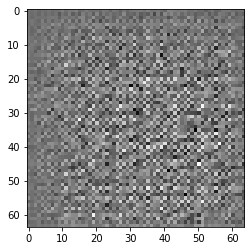

In [ ]:
#testing

generator= generator()
noise= tf.random.normal([1,128],mean=0, stddev=0.2)
generated_image = generator(noise,training=False)
#generated_image= np.resize(generated_image,(64,64,3))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = discriminator()
output= discriminator(generated_image)
print(output)

In [ ]:
#loss functions 
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss= cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss= cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss= real_loss+fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer= Adam()
discriminator_optimizer = Adam()

In [ ]:
epochs=100 
noise_dim= 128 
batch_size= 128

seed = tf.random.normal([batch_size,noise_dim])

In [ ]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        ## Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i])
    filename = f"generated_plot_epoch-{epoch+1}.png"
    plt.savefig(filename)
    plt.close()


if __name__ == "__main__":
    ## Hyperparameters
    batch_size = 128
    latent_dim = 128
    num_epochs = 1000
    images_path = glob("data/data/*")

    d_model = discriminator
    g_model = generator

    # d_model.load_weights("saved_model/d_model.h5")
    # g_model.load_weights("saved_model/g_model.h5")

    d_model.summary()
    g_model.summary()

    gan = GAN(d_model, g_model, latent_dim)

    bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

    images_dataset = tf_dataset(images_path, batch_size)

    for epoch in range(num_epochs):
        gan.fit(images_dataset, epochs=1)
        g_model.save("g_model.h5")
        d_model.save("d_model.h5")

        n_samples = 25
        noise = np.random.normal(size=(n_samples, latent_dim))
        examples = g_model.predict(noise)
        save_plot(examples, epoch, int(np.sqrt(n_samples)))


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)     

KeyboardInterrupt: ignored

In [ ]:
#testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


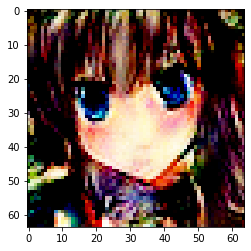

In [ ]:
model = load_model("g_model.h5")

n_samples = 1     ## n should always be a square of an integer.
latent_dim = 128
latent_points = np.random.normal(size=(n_samples, latent_dim))
prediction = model.predict(latent_points)

prediction = np.resize(prediction,(64,64,3))
plt.imshow(prediction,vmin=0, vmax=255)


In [ ]:
anim_file = 'training_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)